# A generic notebook to perform analysis of SWAXS data at FORMAX

# Part I - file structure.

The data we have at FORMAX is gathered by two sensors. 

- lambda, which measures the Wide Angle X-ray Scattering (WAXS)
- eiger, which measures the Small Angle X-ray Scattering (SAXS)

The sensors measure the number of photon hitting each pixel for a given exposure time. This is the raw data.

For each scan, there are three files that are stored as [h5 files](https://www.hdfgroup.org/solutions/hdf5/) in the raw/ folder, which houses this data:

- scan-xxxx.h5: The master file for the scan, containing useful metadata for the scan.
- scan-xxxx_lambda.h5: The data from the lambda sensor.
- scan-xxxx_eiger.h5: The data from the eiger sensor.


Let us load the data first. We will also create a function that gives us the appropriate file path to use. 

In [2]:

import h5py #Open and manage h5 files with python
#with this, h5 files can be navigated in a similar way to python dictionaries, which is very convenient.
import hdf5plugin #Loading the raw data will not work without it
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


In [3]:
scan = 35

In [4]:
def get_fpath(scan, det, raw = False):
    """
    Returns the appropriate file path, depending on parameters

    Arguments:
        - scan (int): The scan number
        - det (str): "lambda" or "eiger" for either detector.
        - raw (bool): Whether to load the raw data (True) or the azimuthally integrated one (False)
        - proposal: The proposal number
        - visit: The visit number
    """
    if raw:
        fpath = f'../data/scan-%04d_{det}.h5' %scan    
    else:
        fpath = f'../data/scan-%04d_{det}_integrated.h5' %scan
    return fpath
    

## Raw sensor data plotting

Let us load the raw sensor data and plot it.

In [5]:
def plot_raw_lambda_data(filepath,which_image, ax = None):
    """Reads the raw data from the lambda hdf5 file and reconstructs the image.
    Because of the there are 4 detectors arranged in a windmill shape, the image need to be reconstructed before plotting.

    Arguments:
        - filepath: The filepath where the data is
        - which_image (int): Each scan is composed of multiple measurements. In our case, each measurement is
    part of a snake_scan, where we move the sample in a snake like pattern between each measurement.
        - ax: The matplotlib ax in which to plot. If left to None, plot to the current ax.
    """
    # filepath = os.path.join(DATA_FOLDER, 'scan-%04d_%s.h5' % (nbr, 'lambda'))
    ax = plt.gca() if ax is None else ax
    with h5py.File(filepath, 'r') as fh:
        full_shape = fh['/entry/instrument/lambda/full_shape'][()]
        rotation = fh['/entry/instrument/lambda/rotation'][()]
        x = fh['/entry/instrument/lambda/x'][()]
        y = fh['/entry/instrument/lambda/y'][()]
        data = fh['/entry/instrument/lambda/data'][which_image,:,:,:]
    fulldata = np.empty(full_shape)
    fulldata[:] = np.nan
    for i in range(4):
        rotdata = np.rot90(data[i,:,:], -rotation[i]/90) # rotate each detector
        fulldata[y[i]:y[i]+rotdata.shape[0],x[i]:x[i]+rotdata.shape[1]] = rotdata
    ax.imshow(fulldata, norm = "log")



def plot_raw_eiger_data(filepath,which_image, ax = None):
    """Reads the raw data from the eiger hdf5 file and reconstructs the image.

    Arguments:
        - filepath: The filepath where the data is
        - which_image (int): Each scan is composed of multiple measurements. In our case, each measurement is
    part of a snake_scan, where we move the sample in a snake like pattern between each measurement.
        - ax: The matplotlib ax in which to plot. If left to None, plot to the current ax.
    """
    ax = plt.gca() if ax is None else ax
    with h5py.File(filepath, 'r') as fh:
        data = np.array(fh['/entry/instrument/eiger/data'][which_image,:,:]).astype(np.float32)
       
    # set values above 1e9 to NaN
    data[data>1.e9] = np.nan
    ax.imshow(data, norm = mcolors.SymLogNorm(1e-3, vmin=1e-1, vmax=1e2), origin='lower')

In [6]:
get_fpath(scan, "lambda", raw = True)

'../data/scan-0035_lambda.h5'

Text(0.5, 1.0, 'SAXS')

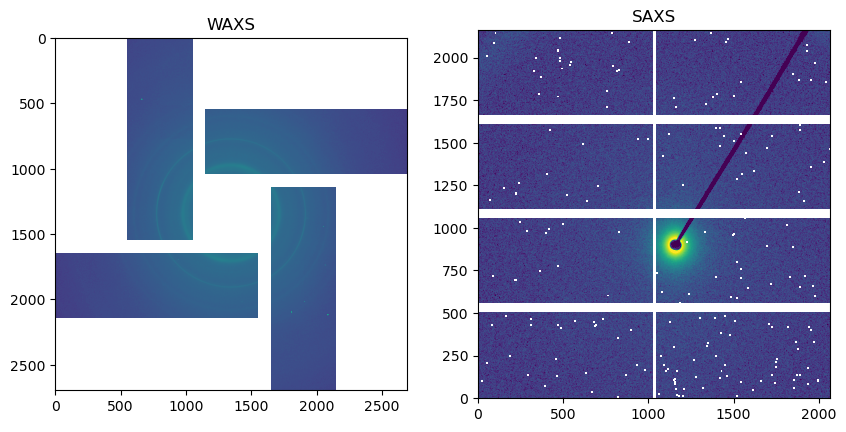

In [7]:
fpath_eiger = get_fpath(scan,"eiger",raw = True)
fpath_lambda = get_fpath(scan,"lambda",raw = True)

fig, [ax1,ax2] = plt.subplots(1,2, figsize = (10,10))

image_number = 500 #Each scan consists of a lot of measurements, here as part of a "snake scan"

plot_raw_lambda_data(fpath_lambda,1000,ax1)
ax1.set_title("WAXS")


plot_raw_eiger_data(fpath_eiger,2000,ax2)
ax2.set_title("SAXS")

## Azimuthal integrated data

Stored this way, the data is not really useful. We have to account for the relative position of each detector plate, and we have our data in cartesian coordinate. For most applications, we are interested in measuring our intensities $I$ as a function of the modulus of the scattering vector $|\mathbf{q}| = \frac{4 \pi \sin \theta}{\lambda}$, and the azimuthal angle $\xi$.

Moving from the cartesian coordinate of the sensor $I(x,y)$ to the radial coordinate system $I(\theta,\xi)$ is called azimuthal integration, and this is done automatically for each scan at MAX IV. We also like to express I as a function of $q$ instead of $\theta$, so we do the change of variable to get $I(q,\xi)$  The azimuthally integrated data is available in the /process/azint/ folder. For each scan, there are two files with the name scan-xxxx_detector_integrated.py where detector is either lambda or eiger. 


In [8]:
def load_azint_data(scan, det , proposal =20240661, visit =  2024102408):
    """
    Load the azimuthal integrated data and returns a dictionary with the keys that are explained below
    
    Arguments:
     - proposal: The proposal number
     - visit: The visit number
     - scan: The scan number
     - det: "eiger" (For SAXS data) or "lambda" (for WAXS data)
    
    keys in file that will be loaded
        **FROM AZINT FILE**
        'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
        'azi', : azimuthal bins
        'mask_file', : file path for mask used for radial integration
        'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
        'polarization_factor', : polarisation factor used for integration
        'poni_file', : file path for pony file
        'q', : q Vektor for integration
        **FROM MASTER FILE**
        'i_t', : diode data, transmittance for 2D map
        'dt' : exposure time from eiger/lambda/diode
        'title' :  scan command from SPOCK
        'swaxs_x' : swaxs_x stage position (encoder reading)
        'swaxs_y' : swaxs_y stage position (theoretical reading)
        'swaxs_rot' : swaxs_y stage position (theoretical reading)
        'time' : time point for triggers for exposure
    """

    filepath = get_fpath(scan,det,False)
    
    data = {}
    items = {
         'I': 'entry/data2d/cake',
         'q': 'entry/data1d/q',
         'azi' : 'entry/data2d/azi',
         'mask_file':'entry/azint/input/mask_file',
         'norm':'entry/data2d/norm',
         'polarization_factor':'entry/azint/input/polarization_factor',
         'poni':'entry/azint/input/poni',   
    }
    with h5py.File(filepath, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]  
            
    # master file
    master = filepath.replace('process/azint', 'raw')
    master = master.replace('_%s_integrated' %det, '')
    items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',   
         'title': 'entry/title'                       
    }
    with h5py.File(master, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]
    #The command used has information on the snake scan performed, we use it. 
    data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    return data



Let us load the azimuthal integrated data from the lambda detector (Wide angle). 

In [9]:
data = load_azint_data(scan,"lambda")
I = data["I"]
azi = data["azi"]
q = data["q"]
shape = data["shape"]
print(f"The shape of the intensity function is {I.shape} (number of img, azimuthal angle, q)")
print(f"There are {azi.shape} azimuthal angle measurements, ranging from {azi[0]} to {azi[-1]} degrees")
print(f"There are {q.shape} q measurements, ranging from q = {q[0]:.2e} to q = {q[-1]:.2e} Å^-1")
print(f"The scan consists of images for {shape[0]} rows and {shape[1]} columns")

The shape of the intensity function is (3050, 180, 2000) (number of img, azimuthal angle, q)
There are (180,) azimuthal angle measurements, ranging from 1.0 to 359.0 degrees
There are (2000,) q measurements, ranging from q = 3.85e-03 to q = 6.88e+00 Å^-1
The scan consists of images for 61 rows and 50 columns


# PART II -  Some common plots

We have everything we need to proceed with the analysis. It is a good idea to proceed with some simple visualizations. The first order of business is to visualize the snake scan. Images are ordered sequentially by max IV but they do not relate to the spatial position of the sample, and for this reason it is nice to think of the images  as a specific row and column coordinate in the scan, with the (0,0) coordinate being the top left corner. 

In [10]:
def reshape_I(data):
    """ Reshape the intensity function to have its first two coordinate being the row and the column
    Args:
        data (_type_): The data to use. 

    With I(img_number,azi,q) as input, the output is I(row,column,azi,q)
    """
    I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))    
    I_flipped = np.copy(I)
    #Since it is a snake scan, we need to flip every other row.
    I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
    return I_flipped

I_flipped = reshape_I(data)
print(f"The new shape is {I_flipped.shape} (row,column,azi,q)")
data["I"] = I_flipped

The new shape is (61, 50, 180, 2000) (row,column,azi,q)


In [11]:
def average_azi(data,azi_min = 0,azi_max = 360):
    """
    Integrate (average) the intensity between the specified minimum azimuthal angle and the maximum one
    """
    I = data["I"]
    q = data["q"]
    azi = data["azi"]
    w = data["norm"] #Weight matrix for the weighted mean
    indx_min = np.where(azi >= azi_min)[0][0]
    indx_max = np.where(azi < azi_max)[0][-1]

    #Filtering the data to includes only the relevant azimuthal angles
    I_azi = I[...,indx_min:indx_max+1,:]
    w_azi = w[indx_min:indx_max+1]

    norm_sum = np.sum(w_azi,axis = 0) #Sum of the weights accross all considered azi angles
    ndim = len(np.shape(I)) #So that it works on either original data, or reshaped
    if(ndim == 3):
        I_times_norm = I_azi*w_azi[None,:,:] #Weighted measurements
        I_avg = np.sum(I_times_norm,axis = 1) / norm_sum[None,:]
    elif(ndim == 4):
        I_times_norm = I_azi*w_azi[None,None,:,:] #Weighted measurements
        I_avg = np.sum(I_times_norm,axis = 2) / norm_sum[None,None,:]
    else:
        raise ValueError("Incompatible number of dimensions for the intensity")
    return I_avg

In [12]:
I_avg = average_azi(data)

print(f"The shape of the average intensity accross azi is {I_avg.shape} (row,col,q)")

The shape of the average intensity accross azi is (61, 50, 2000) (row,col,q)


/var/folders/t6/kdy5g1ls14lg68s7mt2m57bh0000gn/T/ipykernel_4521/101774920.py:23: RuntimeWarning: invalid value encountered in divide
  I_avg = np.sum(I_times_norm,axis = 2) / norm_sum[None,None,:]


We then average accross q to get an idea of how much diffraction there is for each image.

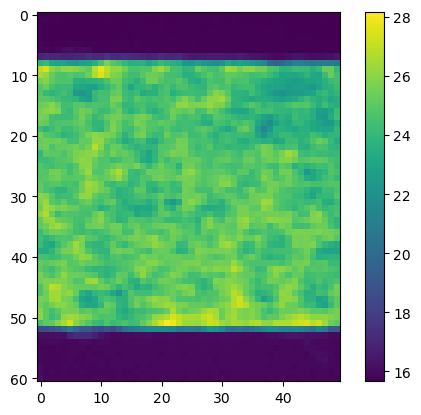

In [13]:
I_avg_avg = np.nanmean(I_avg,axis = 2)

fig , ax = plt.subplots()
diffraction = ax.imshow(I_avg_avg)
fig.colorbar(diffraction,ax = ax)

We can now plot the intensity against the value of q. In this case, we will assume that there is no prefered orientation for the material so we integrate accross every azimuthal angles. 

Text(0, 0.5, 'I (A.U)')

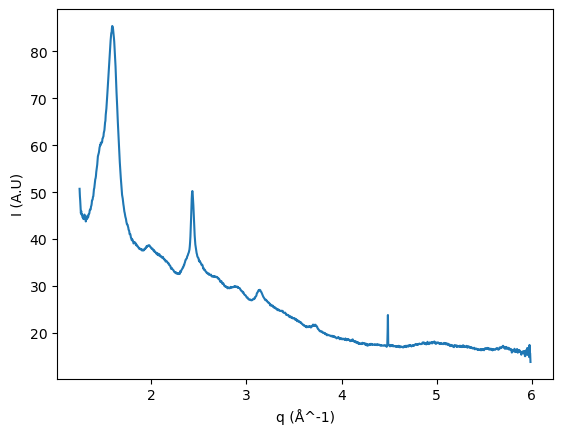

In [14]:
plt.plot(data["q"],I_avg[10,10])
plt.xlabel("q (Å^-1)")
plt.ylabel("I (A.U)")

Note that in the above figure, the resulting intensity is due to the diffraction of the scanned sample, but also the air around it as well as the sample environment. We would need to do some background substraction to analyse the data further.

Text(0.5, 1.0, 'Average intensity for different rows')

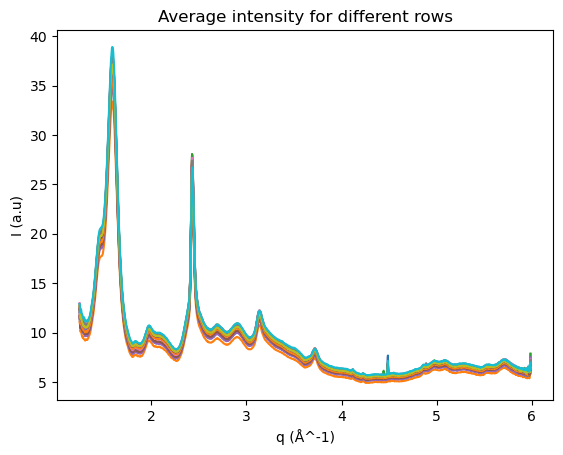

In [15]:

for i in range(10, 50,2):
    plt.plot(data["q"],np.mean(I_avg[i], axis =0)-np.mean(I_avg[0,:],axis = 0))
plt.xlabel("q (Å^-1)")
plt.ylabel("I (a.u)")
plt.title("Average intensity for different rows")


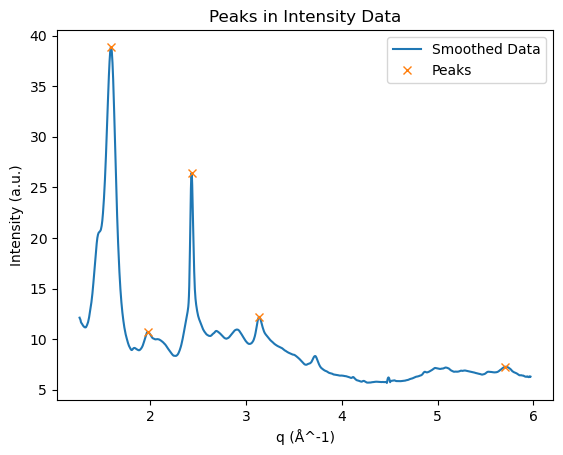

In [ ]:
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
import numpy as np

# Compute the y-data
y_data = np.mean(I_avg[i], axis=0) - np.mean(I_avg[0, :], axis=0)

# Smooth the data to reduce noise
smoothed_y = savgol_filter(y_data, window_length=11, polyorder=3)

# Find peaks
peaks, properties = find_peaks(smoothed_y, prominence=1, width=5)

# Plot the results
plt.plot(data["q"], smoothed_y, label="Smoothed Data")
plt.plot(data["q"][peaks], smoothed_y[peaks], "x", label="Peaks")
plt.xlabel("q (Å^-1)")
plt.ylabel("Intensity (a.u.)")
plt.title("Peaks in Intensity Data")
plt.legend()
plt.show()

In [ ]:
# Check for NaN or Inf values in y_data
nan_indices = np.isnan(y_data)
inf_indices = np.isinf(y_data)

# print("NaN indices:", np.where(nan_indices)[0])
# print("Inf indices:", np.where(inf_indices)[0])

# Remove NaN or Inf values
valid_indices = ~(nan_indices | inf_indices)
clean_q = data["q"][valid_indices]
clean_y = y_data[valid_indices]

Number of Peaks to Fit: 10


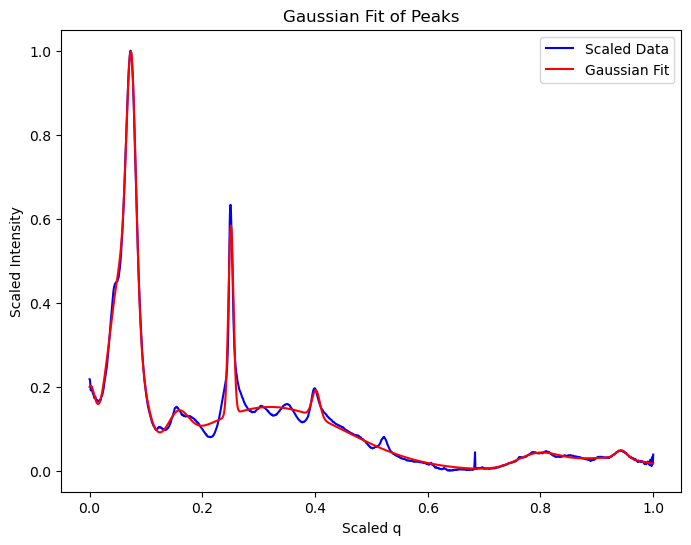

Fitted Parameters (Scaled): [1.12956286e-02 7.39206518e-02 8.10020578e-03 5.08852253e-03
 2.50694109e-01 4.49685609e-03 3.25918645e-03 1.56712445e-01
 1.87906079e-02 3.08398668e-02 6.00034250e-02 2.60421523e-02
 5.85771482e-03 9.17630860e-01 7.71814640e-02 5.17228902e-02
 3.20786027e-01 1.35924068e-01 5.03466646e-04 9.43467899e-01
 1.04604397e-02 3.21444934e-03 7.94664706e-01 3.78500910e-02
 1.11815033e-03 4.01643714e-01 6.90775821e-03 3.58721892e-03
 2.59736612e-21 9.12100962e-03]


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import norm

# Scale input data
clean_q_scaled = (clean_q - np.min(clean_q)) / (np.max(clean_q) - np.min(clean_q))
clean_y_scaled = (clean_y - np.min(clean_y)) / (np.max(clean_y) - np.min(clean_y))

# Find peaks directly in the cleaned data
peak_indices, properties = find_peaks(clean_y_scaled, prominence=0.001, width=5)  # Adjust prominence as needed
sorted_indices = np.argsort(properties["prominences"])[::-1]  # Sort peaks by decreasing prominence

# Number of peaks to fit
max_peaks_to_fit = 10  # Maximum number of peaks to fit, gaussian fit cannot handle too many
num_peaks_to_fit = min(len(peak_indices), max_peaks_to_fit)  # Use at most max_peaks_to_fit peaks
print(f"Number of Peaks to Fit: {num_peaks_to_fit}")

# Sort peaks by prominence descending and select the top ones
sorted_indices = np.argsort(properties["prominences"])[::-1]  # Sort peaks by prominence descending
selected_peaks = peak_indices[sorted_indices[:num_peaks_to_fit]]
selected_prominences = properties["prominences"][sorted_indices[:num_peaks_to_fit]]
selected_widths = properties["widths"][sorted_indices[:num_peaks_to_fit]]

# Construct initial guesses
initial_guess = []
for i in range(num_peaks_to_fit):
    A = selected_prominences[i]  # Use prominence as an estimate for amplitude
    mu = clean_q_scaled[selected_peaks[i]]  # Peak position
    sigma = selected_widths[i] / (2.355 * (clean_q_scaled[1] - clean_q_scaled[0]))  # Convert FWHM to sigma
    initial_guess.extend([A, mu, sigma])

# Define the Gaussian model using scipy.stats.norm
def multi_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        A, mu, sigma = params[i:i+3]
        y += A * norm.pdf(x, loc=mu, scale=sigma)  # Using scipy's built-in norm.pdf
    return y

# Define bounds
lower_bounds = [0, 0, 0] * num_peaks_to_fit  # Amplitude >= 0, position >= 0, width >= 0
upper_bounds = [2 * max(clean_y_scaled), 1.0, 0.2] * num_peaks_to_fit  # Adjust upper bounds as necessary

# Ensure initial guess is within bounds
initial_guess = np.clip(initial_guess, lower_bounds, upper_bounds)

# Fit the Gaussian model to the data
try:
    popt, _ = curve_fit(
        multi_gaussian, clean_q_scaled, clean_y_scaled,
        p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=1000
    )
except RuntimeError as e:
    print("Fit failed:", e)
    popt = initial_guess  # Use initial guess if fit fails

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(clean_q_scaled, clean_y_scaled, label="Scaled Data", color='blue')
plt.plot(clean_q_scaled, multi_gaussian(clean_q_scaled, *popt), label="Gaussian Fit", color='red')
plt.xlabel("Scaled q")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.title("Gaussian Fit of Peaks")
plt.show()

print("Fitted Parameters (Scaled):", popt)